### Hello. This notebook will be exploring some preliminary data sets.###
**In case you're wondering, my project is going to be tracking (and predicting) breakthrough technologies by modeling technology mentions in Academic Journals, Popular Media, and Job Postings . Enjoy!**

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

**In this preliminary exploration I will only be looking at mentions of "Machine Learning" or "ML"**

In [3]:
# The first prelim dataset is from naukri: 
jobs= pd.read_csv('./data/NaukriJobs_kaggle/naukri_com-job_sample.csv')

jobs.info()
# I am interested in the Launch Date, the Course Title, 

#Have to look at the range of dates, for sampling purposes
# jobs['postdate'].sort_values()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 14 columns):
company                21996 non-null object
education              20004 non-null object
experience             21996 non-null object
industry               21995 non-null object
jobdescription         21996 non-null object
jobid                  22000 non-null int64
joblocation_address    21499 non-null object
jobtitle               22000 non-null object
numberofpositions      4464 non-null float64
payrate                21903 non-null object
postdate               21977 non-null object
site_name              3987 non-null object
skills                 21472 non-null object
uniq_id                22000 non-null object
dtypes: float64(1), int64(1), object(12)
memory usage: 2.3+ MB


## Naukri Date Ranges: 1/2015 - 1/2017

In [4]:
# Curtesy of 
#https://stackoverflow.com/questions/842856/whats-the-most-efficient-way-to-find-one-of-several-substrings-in-python

def wordlist_to_regex(words):
    escaped = map(re.escape, words)
    combined= '|'.join(sorted(escaped, key=len, reverse=True))
    return re.compile(combined)

In [5]:
mlwords=[' Virtual Reality ', 
         ' Augmented Reality ']
myregs= wordlist_to_regex(mlwords)

In [6]:
wordmatch_mask=[myregs.search(s.lower()) != None for s in jobs['jobdescription'] if isinstance(s, str)]

In [ ]:
jobs.columns

In [7]:
# If I decide to update the schema, might include some of ^^ these as well
mljobs=jobs.loc[wordmatch_mask,['postdate', 'jobdescription', 'jobtitle', 'skills', 'uniq_id']]

## Naukri has zero jobs with AR/VR ##

## The Schema I want: ##

**Date, id, source**

## Ok that was the first dataset. Let's try loading some more...##

**The PushShift API provides a nice aggregator for Reddit, so it makes my job easy for that site!**


In [12]:
import requests, json

def pushshift_to_the_limit(search_term):
    
    '''Requires pandas, requests and json library. Aggregates mentions of search term on Reddit thru comments and submissions'''
    
    comment_url= "https://api.pushshift.io/reddit/search/comment/"
    subm_url= "https://api.pushshift.io/reddit/search/submission/"
    
    comm_json= requests.get(f"{comment_url}?q={search_term}&aggs=created_utc&frequency=day&size=0")
    subm_json= requests.get(f"{subm_url}?q={search_term}&aggs=created_utc&frequency=day&size=0")
    comm_data=json.loads(comm_json.content)['aggs']['created_utc']
    subm_data=json.loads(subm_json.content)['aggs']['created_utc'] ##Now the data are in array format
    
    # Organize the responses into dicts, to load to pandas
    
    comm_dict={
        "day":[ x['key'] for x in comm_data],
        f"comments":[x['doc_count'] for x in comm_data],
    }
    subm_dict={
        "day":[ x['key'] for x in subm_data],
        f"submissions":[x['doc_count'] for x in subm_data],
    }
    
    comm_df= pd.DataFrame(comm_dict)
    comm_df.day=pd.to_datetime(comm_df.day, unit='s') 
    
    subm_df= pd.DataFrame(subm_dict)
    subm_df.day=pd.to_datetime(subm_df.day, unit='s') 
    
    tot_df=comm_df.merge(subm_df, on='day', how='outer').fillna(0)
    
    tot_df['total']=tot_df['comments']+tot_df['submissions']
    
    return tot_df

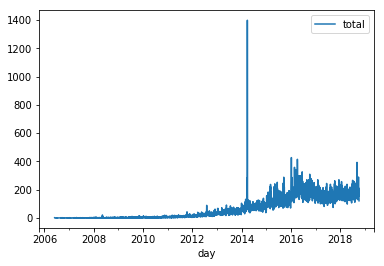

In [13]:
vr_df=pushshift_to_the_limit('virtual reality')
vr_df.plot('day', 'total')

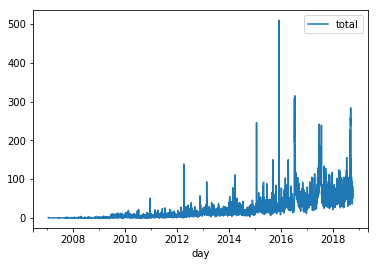

In [15]:
ar_df=pushshift_to_the_limit('augmented reality')
ar_df.plot('day', 'total')

In [16]:
ar_df.to_csv('./cleaned_data/reddit_augmented_reality.csv')
vr_df.to_csv('./cleaned_data/reddit_virtual_reality.csv')

## Interesting to compare and contrast the two... ##

**OK so we've looked (preliminarily) at Job postings and social mentions. How about academic literature?**

### Scratch that. [Scholarly](https://pypi.org/project/scholarly/0.2/) is a nice api, but it doesn't provide a key field, date, easily ###
**You have to .fill() the generator it returns, which takes a long time, is expensive, and causes 403 forbidden errors quite a bit. _Note to future self: modify the source code to return date with the first call_**

In [17]:
#instead let's focus on a nice easy-to-use api: arXiv
import urllib
import time
import feedparser

In [19]:
def arx_and_recreation(search_term, start_idx, scope='ti'):
    '''uses urllib, time, and feedparser'''
    #first escape search terms
    search_term= search_term.replace('"',"%22").replace(" ", "+");
    # set wait time and iteration step
    iterstep= 200;
    wait_time= 2 #make this 3 to 'play nice' with the api. I am nice I promise! but impatient atm
    base_url = 'http://export.arxiv.org/api/query?'
    start= start_idx
    date_dict={
        "date":[],
        "article_id": [],
        "source": "arXiv"
    }
    while True:
        response= urllib.request.urlopen(base_url+f"search_query={scope}:{search_term}&sortBy=submittedDate&sortOrder=ascending&start={start}&max_results={iterstep}")
        feed= feedparser.parse(response)
        if not feed.entries:
            print('query complete')
            print(f"There should be {feed.feed.opensearch_totalresults} results?")
            break
        date_dict['date'].extend([entry.published for entry in feed.entries])
        date_dict['article_id'].extend([entry.id.split('/abs/')[-1] for entry in feed.entries])
        print(f"gathering results {start} to {start + iterstep-1} ")
        start = start + iterstep
        time.sleep(wait_time)
        
    return pd.DataFrame(date_dict)
        
    

In [21]:
test_ar = arx_and_recreation('"virtual reality" OR "augmented reality"',0)

gathering results 0 to 199 
gathering results 200 to 399 
query complete
There should be 339 results?


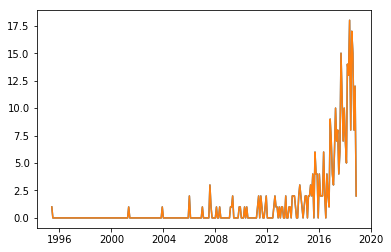

In [23]:
test_ar['date'] = pd.to_datetime(test_ar['date'])
test_ar.set_index('date', inplace=True)
plt.plot(test_ar.resample('M').count());

In [24]:
test_ar.to_csv('./cleaned_data/arXiv_aug_virt_reality.csv')